# Notebook to get wind offshor data to include in the optimization model

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, MultiLineString
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from pyproj import Transformer
import folium
from folium import Choropleth
import matplotlib.pyplot as plt
from shapely.geometry import Point


We get points on the coastline that are regularly spaced. For now, the points are on the coastline. In a future development, it would be better to take points 20km away from the shore to have a better assessment of offshore wind power potential.https://www.researchgate.net/publication/342040498_Review_of_the_current_status_technology_and_future_trends_of_offshore_wind_farms/figures?lo=1&utm_source=google&utm_medium=organic

In [2]:
# Load the Natural Earth coastline dataset
gdf = gpd.read_file('shapefiles/coastlines/ne_110m_coastline.shp')

# Project to a metric coordinate system (e.g., EPSG:3395)
gdf = gdf.to_crs(epsg=3395)

# Extract the coordinates from the coastline geometries
points = []
for geom in gdf.geometry:
    if isinstance(geom, MultiLineString):
        for line in geom.geoms:
            points.extend(list(line.coords))
    elif isinstance(geom, LineString):
        points.extend(list(geom.coords))

# Reduce the number of points for a smaller dataframe, for example, every 10th point
points = points[::10]

# Initialize the geocoder
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

# Initialize the transformer to convert coordinates from EPSG:3395 to EPSG:4326
transformer = Transformer.from_crs("EPSG:3395", "EPSG:4326", always_xy=True)

# Reverse geocoding to get countries
data = []
for point in points:
    try:
        # Convert coordinates to EPSG:4326 (latitude, longitude)
        lon, lat = transformer.transform(point[0], point[1])
        location = geocode((lat, lon), exactly_one=True)
        if location:
            country = location.raw['address'].get('country', '')
            data.append((lat, lon, country))  # (latitude, longitude, country)
    except Exception as e:
        print(f"Error with point {point}: {e}")

# Create a dataframe
df = pd.DataFrame(data, columns=['Latitude', 'Longitude', 'Country'])

# Display the first few rows
print(df.head())

df.to_csv('wind_offshore_points.csv')


RateLimiter caught an error, retrying (0/2 tries). Called with (*((-78.59566741324154, -163.7128956777287),), **{'exactly_one': True}).
Traceback (most recent call last):
  File "s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\.conda\lib\site-packages\urllib3\connectionpool.py", line 467, in _make_request
    self._validate_conn(conn)
  File "s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\.conda\lib\site-packages\urllib3\connectionpool.py", line 1099, in _validate_conn
    conn.connect()
  File "s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\.conda\lib\site-packages\urllib3\connection.py", line 653, in connect
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
  File "s:\131-DPE\131.1-Temporaire\131.1.1-Espace comm

In [10]:
df = pd.DataFrame(data, columns=['Latitude', 'Longitude', 'Country'])

In [16]:
# Initialize a folium map centered around the mean location
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=3)

# Add points to the map
for _, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Country'],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Save to an HTML file
m.save('map.html')

# To display the map in a Jupyter notebook (optional):
from IPython.display import IFrame
IFrame(src='map.html', width=800, height=600)


C:\Users\JD278300\AppData\Local\Temp\ipykernel_19720\2231494979.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


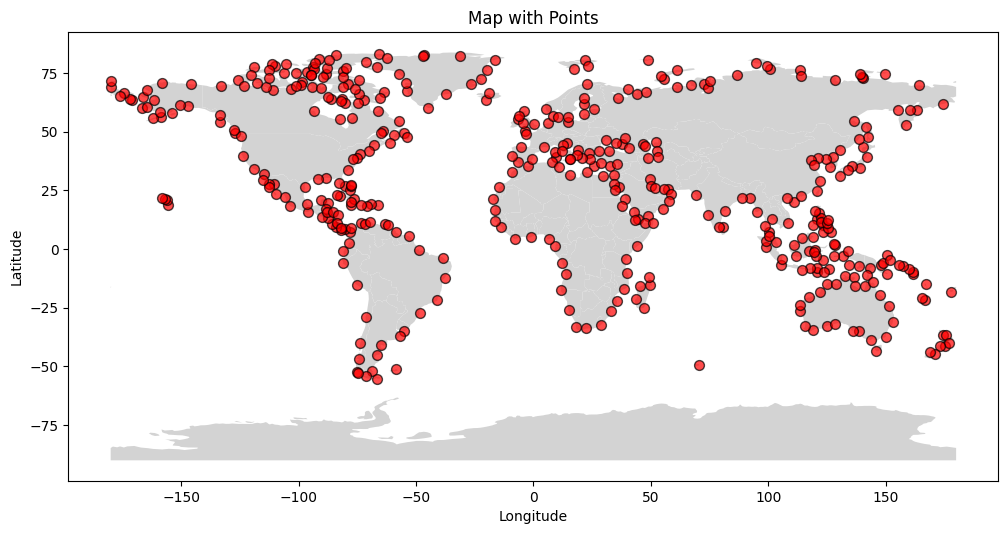

In [19]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Load world boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey')

# Plot the points
gdf.plot(ax=ax, color='red', markersize=50, edgecolor='black', alpha=0.7)

# Add labels
# for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.Country):
#     ax.text(x, y, label, fontsize=12, ha='right')

# Set title and labels
ax.set_title('Map with Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()
